Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-15-e484a72edded>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


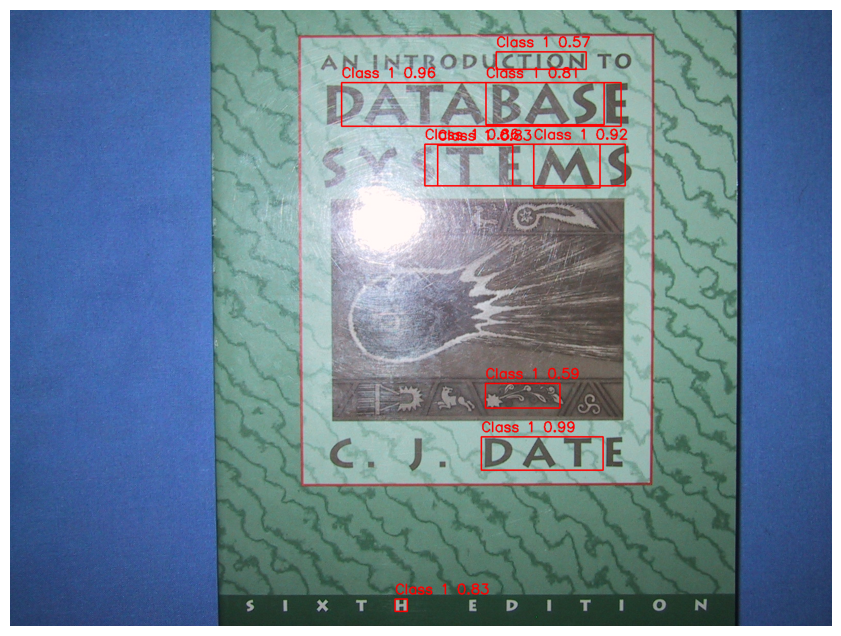

In [15]:
import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import cv2
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

# Загрузка модели Faster R-CNN из файла
def load_model(model_path, num_classes=2):
    # Создаем модель Faster R-CNN с backbone ResNet-50 и FPN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes)

    # Загружаем веса модели из файла
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

# Путь к файлу с весами модели
model_path = '/content/drive/MyDrive/3_SEMESTR/CV/CVproject/faster_rcnn_text_detection.pth'  # Укажите путь к вашему файлу с моделью
model = load_model(model_path)

# Загрузка изображения
image_path = '/content/drive/MyDrive/3_SEMESTR/CV/CVproject/ICDAR2013/Challenge2_Test_Task12_Images/img_40.jpg'  # Укажите путь к вашему изображению
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Преобразуем в RGB

# Преобразование изображения в тензор
transform = T.Compose([T.ToTensor()])
image_tensor = transform(image)

# Применение модели к изображению
with torch.no_grad():
    prediction = model([image_tensor])

# Функция для отрисовки bounding box'ов
def draw_boxes(image, boxes, labels, scores, threshold=0.5):
    for i, box in enumerate(boxes):
        if scores[i] > threshold:
            box = box.numpy().astype(np.int32)
            cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
            cv2.putText(image, f'Class {labels[i]} {scores[i]:.2f}', (box[0], box[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    return image

# Получение предсказанных bounding box'ов, меток и уверенностей
boxes = prediction[0]['boxes']
labels = prediction[0]['labels']
scores = prediction[0]['scores']

# Отрисовка bounding box'ов на изображении
image_with_boxes = draw_boxes(image, boxes, labels, scores)

# Отображение изображения с bounding box'ами
plt.figure(figsize=(12, 8))
plt.imshow(image_with_boxes)
plt.axis('off')
plt.show()

In [14]:
import os
import torch
import numpy as np
import cv2
from torchvision import transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Функция для парсинга GT файлов
def parse_gt_file(gt_file_path):
    """
    Парсит GT файл и возвращает список bounding boxes.
    """
    gt_boxes = []
    with open(gt_file_path, 'r') as f:
        for line in f:
            # Удаляем лишние символы (например, запятые) и разбиваем строку на части
            parts = line.strip().replace(',', '').split()
            # Преобразуем первые 4 значения в целые числа
            x1, y1, x2, y2 = map(int, parts[:4])
            gt_boxes.append([x1, y1, x2, y2])
    return np.array(gt_boxes)

# Функция для расчета IoU
def calculate_iou(box1, box2):
    """
    Рассчитывает Intersection over Union (IoU) для двух bounding boxes.
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    iou = inter_area / (box1_area + box2_area - inter_area + 1e-9)
    return iou

# Функция для расчета метрик
def calculate_metrics(pred_boxes, true_boxes, iou_threshold=0.5):
    """
    Рассчитывает Precision, Recall и F1-score.
    """
    if len(pred_boxes) == 0:
        return 0.0, 0.0, 0.0, 0, 0, 0  # Если нет предсказаний, метрики равны 0

    if len(true_boxes) == 0:
        return 0.0, 0.0, 0.0, 0, 0, 0  # Если нет истинных объектов, метрики равны 0

    # Матрица IoU между предсказанными и истинными bounding boxes
    iou_matrix = np.zeros((len(pred_boxes), len(true_boxes)))
    for i, pred_box in enumerate(pred_boxes):
        for j, true_box in enumerate(true_boxes):
            iou_matrix[i, j] = calculate_iou(pred_box, true_box)

    # Жадное сопоставление: каждый истинный объект сопоставляется с одним предсказанным bounding box
    tp = 0
    matched_true_indices = set()  # Индексы истинных объектов, которые уже сопоставлены
    for i in range(len(pred_boxes)):
        max_iou_idx = np.argmax(iou_matrix[i])
        if iou_matrix[i, max_iou_idx] >= iou_threshold and max_iou_idx not in matched_true_indices:
            tp += 1
            matched_true_indices.add(max_iou_idx)

    # Подсчет FP и FN
    fp = len(pred_boxes) - tp  # False Positives
    fn = len(true_boxes) - tp  # False Negatives

    # Расчет метрик
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)  # Добавляем 1e-9 для избежания деления на 0

    return precision, recall, f1, tp, fp, fn

# Функция для загрузки модели
def load_model(model_path, num_classes):
    """
    Загружает модель Faster R-CNN из файла.
    """
    model = fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Загрузка модели с указанием устройства (CPU, если CUDA недоступна)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.load_state_dict(torch.load(model_path, map_location=device))

    return model

# Функция для нормализации изображения
def normalize_image(image):
    """
    Нормализует изображение для подачи в модель.
    """
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image)

# Функция для тестирования модели на тестовой выборке
def test_model_on_test_set(model, images_dir, gt_dir, device, iou_threshold=0.5):
    """
    Тестирует модель на тестовой выборке и рассчитывает метрики.
    """
    model.eval()  # Переводим модель в режим оценки
    total_tp = 0
    total_fp = 0
    total_fn = 0

    # Получаем список изображений
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]

    for image_file in image_files:
        # Загрузка изображения
        image_path = os.path.join(images_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Преобразуем в RGB
        image = normalize_image(image)  # Нормализация
        image = image.unsqueeze(0).to(device)  # Добавляем batch dimension

        # Загрузка GT bounding boxes
        gt_file_path = os.path.join(gt_dir, f"gt_{os.path.splitext(image_file)[0]}.txt")
        gt_boxes = parse_gt_file(gt_file_path)

        # Предсказание bounding boxes
        with torch.no_grad():
            preds = model(image)

        # Извлекаем предсказанные bounding boxes
        pred_boxes = preds[0]['boxes'].cpu().numpy()
        pred_scores = preds[0]['scores'].cpu().numpy()

        # Фильтрация предсказаний по порогу уверенности
        confidence_threshold = 0.5
        pred_boxes = pred_boxes[pred_scores >= confidence_threshold]

        # Расчет метрик для текущего изображения
        precision, recall, f1, tp, fp, fn = calculate_metrics(pred_boxes, gt_boxes, iou_threshold)

        # Накопление TP, FP и FN
        total_tp += tp
        total_fp += fp
        total_fn += fn

        # Логирование
        print(f"Изображение: {image_file}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        print(f"TP: {tp}, FP: {fp}, FN: {fn}")
        print("-" * 50)

    # Расчет общих метрик
    total_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    total_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
    total_f1 = 2 * (total_precision * total_recall) / (total_precision + total_recall + 1e-9)

    print("\nИтоговые метрики на тестовой выборке:")
    print(f"Precision: {total_precision:.4f}, Recall: {total_recall:.4f}, F1: {total_f1:.4f}")

# Основной код
if __name__ == "__main__":
    # Загрузка модели
    model_path = '/content/drive/MyDrive/3_SEMESTR/CV/CVproject/faster_rcnn_text_detection.pth'  # Укажите путь к вашему файлу с моделью
    model = load_model(model_path, num_classes=2)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    # Пути к тестовым данным
    images_dir = '/content/drive/MyDrive/3_SEMESTR/CV/CVproject/ICDAR2013/Challenge2_Test_Task12_Images'
    gt_dir = '/content/drive/MyDrive/3_SEMESTR/CV/CVproject/ICDAR2013/Challenge2_Test_Task1_GT (1)'

    # Тестирование модели на тестовой выборке
    test_model_on_test_set(model, images_dir, gt_dir, device, iou_threshold=0.5)

<ipython-input-14-75fee7f651a9>:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Изображение: img_10.jpg
Precision: 0.0000, Recall: 0.0000, F1: 0.0000
TP: 0, FP: 0, FN: 0
--------------------------------------------------
Изображение: img_1.jpg
Precision: 0.7273, Recall: 0.8889, F1: 0.8000
TP: 8, FP: 3, FN: 1
--------------------------------------------------
Изображение: img_111.jpg
Precision: 0.0000, Recall: 0.0000, F1: 0.0000
TP: 0, FP: 3, FN: 3
--------------------------------------------------
Изображение: img_110.jpg
Precision: 0.0000, Recall: 0.0000, F1: 0.0000
TP: 0, FP: 0, FN: 0
--------------------------------------------------
Изображение: img_132.jpg
Precision: 0.7692, Recall: 0.4000, F1: 0.5263
TP: 10, FP: 3, FN: 15
--------------------------------------------------
Изображение: img_133.jpg
Precision: 0.0000, Recall: 0.0000, F1: 0.0000
TP: 0, FP: 0, FN: 0
--------------------------------------------------
Изображение: img_119.jpg
Precision: 0.5000, Recall: 0.6000, F1: 0.5455
TP: 3, FP: 3, FN: 2
--------------------------------------------------
Изображ

Итоговые метрики на тестовой выборке:
Precision: 0.3957, Recall: 0.3138, F1: 0.3500